# Download the Data

In [2]:
!pip3 install tqdm

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/bin/python -m pip install --upgrade pip' command.


In [3]:
%matplotlib inline

import os
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
import boto3
import sagemaker

from tqdm import tqdm
from sagemaker.amazon.amazon_estimator import get_image_uri
from matplotlib import pyplot as plt

urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']

def download_and_extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print('Downloading', url)
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print('Already downloaded', url)

def get_annotations(file_path):
    annotations = {}
    
    with open(file_path, 'r') as f:
        rows = f.read().splitlines()

    for i, row in enumerate(rows):
        image_name, _, _, _ = row.split(' ')
        class_name = image_name.split('_')[:-1]
        class_name = '_'.join(class_name)
        image_name = image_name + '.jpg'
        annotations[image_name] = class_name
    
    return annotations, i + 1

In [4]:
if not os.path.isdir('data'):
    os.mkdir('data')

download_and_extract('data', '.')

Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz


In [5]:
train_annotations, _ = get_annotations('data/annotations/trainval.txt')
test_annotations, _ = get_annotations('data/annotations/test.txt')

In [6]:
all_annotations = {}

for key, value in train_annotations.items():
    all_annotations[key] = value
for key, value in test_annotations.items():
    all_annotations[key] = value

In [7]:
train_annotations = {}
test_annotations = {}

for key, value in all_annotations.items():
    if random.randint(0, 99) < 20:
        test_annotations[key] = value
    else:
        train_annotations[key] = value

In [8]:
train_count = len(list(train_annotations.keys()))
test_count = len(list(test_annotations.keys()))

print(train_count)
print(test_count)

5834
1515


# Visualize Data

In [9]:
classes = list(all_annotations.values())

classes = list(set(classes))

print(classes)
print('\nNum of classes:', len(classes))

['saint_bernard', 'samoyed', 'english_cocker_spaniel', 'yorkshire_terrier', 'Bombay', 'english_setter', 'boxer', 'Birman', 'chihuahua', 'newfoundland', 'Russian_Blue', 'Bengal', 'american_pit_bull_terrier', 'japanese_chin', 'Maine_Coon', 'havanese', 'wheaten_terrier', 'leonberger', 'Sphynx', 'shiba_inu', 'staffordshire_bull_terrier', 'german_shorthaired', 'scottish_terrier', 'american_bulldog', 'pug', 'beagle', 'Siamese', 'Persian', 'Ragdoll', 'Abyssinian', 'Egyptian_Mau', 'pomeranian', 'keeshond', 'basset_hound', 'miniature_pinscher', 'great_pyrenees', 'British_Shorthair']

Num of classes: 37


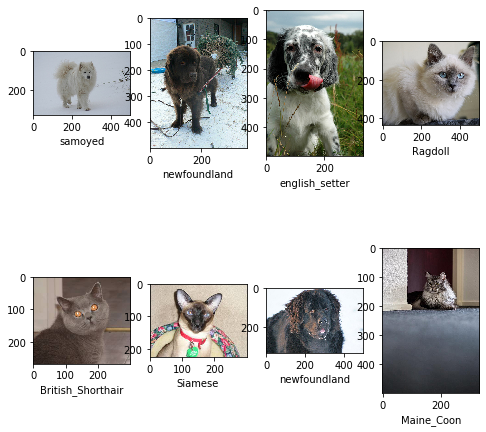

In [10]:
plt.figure(figsize=(8, 8))

train_images = list(train_annotations.keys())

for i in range(0, 8):
    plt.subplot(2, 4, i + 1)
    image = train_images[random.randint(0, train_count - 1)]
    plt.imshow(plt.imread(os.path.join('data/images/', image)))
    plt.xlabel(train_annotations[image])
plt.show()

# SageMaker Setup

In [11]:
role = sagemaker.get_execution_role()
bucket_name = 'imagepets'
training_image = get_image_uri(boto3.Session().region_name, 'image-classification', repo_version = 'latest')
print(training_image)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


825641698319.dkr.ecr.us-east-2.amazonaws.com/image-classification:latest


In [12]:
folders = ['train', 'train_lst', 'validation', 'validation_lst']

for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

# Preparing Data for SageMaker

In [13]:
def prepare_data(annotations, key='train'):
    images = list(annotations.keys())
    f = open(os.path.join(key + '_lst', key + '.lst'), 'w')
    with tqdm(total=len(images)) as pbar:
        for i, image in enumerate(images):
            shutil.copy(os.path.join('data/images/', image), os.path.join(key, image))
            class_id = classes.index(annotations[image])
            f.write('{}\t{}\t{}\n'.format(i, class_id, image))
            pbar.update(1)
    f.close()

In [14]:
prepare_data(train_annotations, 'train')

100%|██████████| 5834/5834 [02:47<00:00, 34.76it/s] 


In [15]:
prepare_data(test_annotations, 'validation')

100%|██████████| 1515/1515 [00:03<00:00, 397.41it/s]


# Uploading Data to S3

In [16]:
%%time
sess = sagemaker.Session()

s3_train_path = sess.upload_data(path='train', bucket=bucket_name, key_prefix='train')
print('Training images uploaded')
s3_train_lst_path = sess.upload_data(path='train_lst', bucket=bucket_name, key_prefix='train_lst')
print('Training list uploaded')
s3_validation_path = sess.upload_data(path='validation', bucket=bucket_name, key_prefix='validation')
print('Validation images uploaded')
s3_validation_lst_path = sess.upload_data(path='validation_lst', bucket=bucket_name, key_prefix='validation_lst')
print('Validation list uploaded')


Training images uploaded
Training list uploaded
Validation images uploaded
Validation list uploaded
CPU times: user 49.4 s, sys: 3.58 s, total: 52.9 s
Wall time: 7min 8s


In [17]:
s3_validation_lst_path

's3://imagepets/validation_lst'

# SageMaker Estimator

In [18]:
#ml.p3.2xlarge has 16 GB of GPU memory

model = sagemaker.estimator.Estimator(training_image, role=role, train_instance_count=1, train_instance_type='ml.p3.2xlarge', train_volume_size=100, train_max_run=36000, input_mode='File', output_path='s3://imagepets/output', sagemaker_session=sess)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


# Hyperparameters

In [19]:
model.set_hyperparameters(num_layers=18, use_pretrained_model=1, image_shape='3,224,224', num_classes=37, mini_batch_size=32, resize=224, epochs=10, learning_rate=0.001, num_training_samples=train_count, augmentation_type='crop_color_transform')

# Data Channels

In [20]:
train_data = sagemaker.session.s3_input(s3_train_path, distribution='FullyReplicated', content_type='application/x-image', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_path, distribution='FullyReplicated', content_type='application/x-image', s3_data_type='S3Prefix')

train_lst_data = sagemaker.session.s3_input(s3_train_lst_path, distribution='FullyReplicated', content_type='application/x-image', s3_data_type='S3Prefix')
validation_lst_data = sagemaker.session.s3_input(s3_validation_lst_path, distribution='FullyReplicated', content_type='application/x-image', s3_data_type='S3Prefix')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [21]:
data_channels ={'train':train_data, 'train_lst':train_lst_data, 'validation':validation_data, 'validation_lst':validation_lst_data}

# Model Training

In [71]:
model.fit(inputs=data_channels, logs=True)

2020-09-14 17:34:10 Starting - Starting the training job...
2020-09-14 17:34:12 Starting - Launching requested ML instances......
2020-09-14 17:35:18 Starting - Preparing the instances for training......
2020-09-14 17:36:24 Downloading - Downloading input data.........
2020-09-14 17:38:04 Training - Downloading the training image.Docker entrypoint called with argument(s): train
[09/14/2020 17:38:21 INFO 140667355617088] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/image_classification/default-input.json: {u'beta_1': 0.9, u'gamma': 0.9, u'beta_2': 0.999, u'optimizer': u'sgd', u'use_pretrained_model': 0, u'eps': 1e-08, u'epochs': 30, u'lr_scheduler_factor': 0.1, u'num_layers': 152, u'image_shape': u'3,224,224', u'precision_dtype': u'float32', u'mini_batch_size': 32, u'weight_decay': 0.0001, u'learning_rate': 0.1, u'momentum': 0}
[09/14/2020 17:38:21 INFO 140667355617088] Merging with provided configuration from /opt/ml/input/config/hyperparameters.json: {u'l

# Deploy Model

In [72]:
deployed_model = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
print('\nModel deployed!')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!
Model deployed!


# Predictions

In [73]:
image_dir = 'validation'
images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

1515


In [74]:
deployed_model.content_type = 'image/jpeg'

In [75]:
index = 1
image_path = os.path.join(image_dir, images[index])
with open(image_path, 'rb') as f:
    b = bytearray(f.read())
    
results = deployed_model.predict(b)
results = json.loads(results)
print(results)

[0.004804582335054874, 0.00016680722183082253, 0.0006065850611776114, 9.467469794799399e-07, 6.341557764244499e-06, 0.0002844332775566727, 0.00013273995136842132, 1.0140925951418467e-05, 2.2522044673678465e-07, 0.004244986921548843, 1.0875371117435861e-05, 1.3700723684451077e-06, 1.5175483895291109e-05, 1.8074730405714945e-06, 1.4077594414629857e-06, 0.0005688956007361412, 0.911848247051239, 0.0459829606115818, 1.752139553445886e-07, 0.00016665791918057948, 1.2502765457611531e-05, 9.405213745594665e-07, 4.99148118251469e-05, 2.968029184557963e-05, 3.518680750858039e-05, 0.0006885186885483563, 1.1389012797735631e-05, 5.2864241297356784e-05, 2.0135476006544195e-06, 9.586998203303665e-06, 1.3536387086787727e-05, 5.670420250680763e-06, 1.672219809734088e-06, 0.0010945695685222745, 1.3132276990290848e-06, 0.029117902740836143, 1.73369626281783e-05]


In [76]:
classes[np.argmax(results)]

'wheaten_terrier'

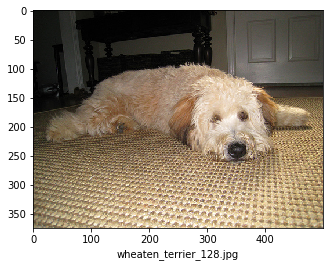

In [77]:
plt.imshow(plt.imread(image_path))
plt.xlabel(images[index])
plt.show()

Don't forget!! You need to delete endpoint or else you will continue to accrue cost!

In [ ]:
sagemaker.Session().delete_endpoint(deployed_model.endpoint)